In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors
from trialblazer import Trialblazer
from trialblazer.Model.testset_visualization import (
    plot_score_distribution_with_significance,
    plot_correlation,
    SuspectedAdverseDrugEvents_count,
    SuspectedAdverseDrugEvents_count_for_eachdrug,
    SuspectedAdverseDrugEvents_Totalcount_for_eachdrug
)

[15:08:01] Initializing Normalizer


In [2]:
def get_logp(mol):
    return round(Crippen.MolLogP(mol), 3)

def cal_mw(mol):
    return round(Descriptors.MolWt(mol), 3)

def select_compounds(predictions, approved_drugs_info):
    predictions['PrOCTOR_score'] = predictions['PrOCTOR_score'].astype(float)
    sorted_predictions = predictions.sort_values(by='PrOCTOR_score', ascending=False, ignore_index=True)
    single_component_predictions = sorted_predictions[~sorted_predictions.id.str.contains(r"\d+x\d+")] # need to remove multi-components because it probably dont't have a name
    top_info, top_drug_names = connect_drug_name(approved_drugs_info, single_component_predictions, head=True)
    bottom_info, bottom_drug_names = connect_drug_name(approved_drugs_info, single_component_predictions, tail=True)
    return top_info, bottom_info, top_drug_names, bottom_drug_names

def connect_drug_name(approved_drugs_info, single_component_predictions, head=False, tail=False):
    if head:
        single_component_predictions = single_component_predictions.head(15)
    elif tail:
        single_component_predictions = single_component_predictions.tail(15)
    single_component_predictions['mol'] = single_component_predictions['smi'].apply(Chem.MolFromSmiles)
    approved_drugs_info = approved_drugs_info.rename(columns={'chembl_id': 'id'})
    approved_drugs_info['id'] = approved_drugs_info['id'].astype(str)
    merged_info = single_component_predictions.merge(approved_drugs_info, how='left', on='id')
    merged_info = merged_info.rename(columns={'name_to_use': 'Name'})
    drug_names = merged_info['Name'].tolist()
    return merged_info, drug_names

In [13]:
Training_data = pd.read_csv("../Data/Training_data_withoutInfo.csv", sep='|')
Testset_data = pd.read_csv("../Data/test_set_data.csv", sep='|')
Training_data_with_features = pd.read_csv("../Data/Training_data_with_features.csv", sep='|')

Check whethere there is overlap between training compounds and test set compounds

In [14]:
training_set_inchi_list = Training_data['inchi_noStereo'].to_list()
print(len(Testset_data[Testset_data['inchi_noStereo'].isin(training_set_inchi_list)]))

0


# Prediction based on M2FPs features or M2FPs+PBFPs features

In [15]:
model_folder='/home/hzhang/python_packages/trialblazer/src/trialblazer/data/last_model'

To reproduce the results from scratch, use the original_testset_data to run the model. This will take approximately a few hours.

In [6]:
# original_testset_data = pd.read_csv("../Data/Testset_raw_with_drugname.csv")

In [8]:
# raw_testdata_SMILES = original_testset_data['SMILES'].tolist()
# model = Trialblazer(model_folder=model_folder)
# model.import_smiles(smiles=raw_testdata_SMILES)
# model.run()
# testset_prediction = model.result.copy()

model prediction based on M2FPs+PBFPs 

In [ ]:
model_combined_feature = Trialblazer(model_folder=model_folder, remove_MultiComponent_cpd=False)
model_combined_feature.test_set=Testset_data
model_combined_feature.run()
prediction_combined_feature = model_combined_feature.result.copy()

model prediction based on M2FPs

In [ ]:
model_M2FP = Trialblazer(model_folder=model_folder, M2FP_only=True, remove_MultiComponent_cpd=False)
model_M2FP.test_set=Testset_data
model_M2FP.run()
prediction_M2FP = model_M2FP.get_dataframe()

# Assign scores to benign and toxic compounds in the training set

In [17]:
benign_set = Training_data_with_features[Training_data_with_features.Mark == 0]
toxic_set = Training_data_with_features[Training_data_with_features.Mark == 1]

model prediction based on M2FPs

In [ ]:
model_M2FP= Trialblazer(model_folder=model_folder, M2FP_only = True, remove_MultiComponent_cpd=False)
model_M2FP.test_set=benign_set
model_M2FP.run()
prediction_benign_set = model_M2FP.result.copy()

In [ ]:
model_M2FP = Trialblazer(model_folder=model_folder, M2FP_only = True, remove_MultiComponent_cpd=False)
model_M2FP.test_set=toxic_set
model_M2FP.run()
prediction_toxic_set = model_M2FP.result.copy()

model prediction based on M2FPs+PBFPs

In [ ]:
model_combined_feature= Trialblazer(model_folder=model_folder, remove_MultiComponent_cpd=False)
model_combined_feature.test_set=benign_set
model_combined_feature.run()
prediction_benign_set = model_combined_feature.result.copy()

In [ ]:
model_combined_feature = Trialblazer(model_folder=model_folder, remove_MultiComponent_cpd=False)
model_combined_feature.test_set=toxic_set
model_combined_feature.run()
prediction_toxic_set = model_combined_feature.result.copy()

## PrOCTOR score distribution for benign, toxic, and test sets

Example of model based on M2FPs+PBFPs features

In [20]:
Testset_withScore = np.array(prediction_combined_feature.PrOCTOR_score)
benign = np.array(prediction_benign_set.PrOCTOR_score)
toxic = np.array(prediction_toxic_set.PrOCTOR_score)

In [21]:
print(np.mean(Testset_withScore).round(2))
print(np.mean(benign).round(2))
print(np.mean(toxic).round(2))

9.89
11.2
-2.88


In [22]:
labels = ("Benign compounds\nTraining set","Toxic compounds\nTraining set","Benign compounds\nTest set")
data = pd.DataFrame({
    "Value": np.concatenate([benign, toxic, Testset_withScore]),
    "Category": np.repeat(labels, repeats=[len(benign), len(toxic), len(Testset_withScore)])
})
p_values = {}
pairs = [("Benign compounds\nTraining set", "Toxic compounds\nTraining set"), ("Toxic compounds\nTraining set", "Benign compounds\nTest set")]  # Pairs of categories to compare
for cat1, cat2 in pairs:
    stat, p = mannwhitneyu(np.array(data[data["Category"] == cat1]["Value"]), np.array(data[data["Category"] == cat2]["Value"]), alternative="two-sided")
    p_values[(cat1, cat2)] = p

/home2/hzhang/python_packages/trialblazer/src/trialblazer/Model/testset_visualization.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x="Category", y="Value", data=data, palette=custom_palette, inner="quartile")


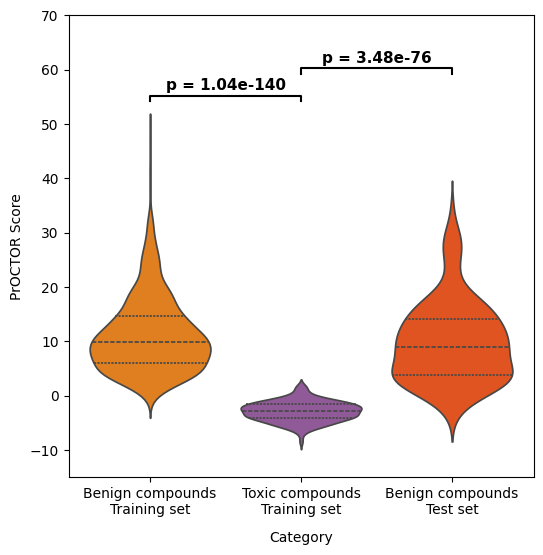

In [23]:
plot_score_distribution_with_significance(data, p_values)

# Select compounds from test set according to PrOCTOR score

In [ ]:
# Removing multi-components in here in order to find the drug name and evaluate the drug later
model_combined_feature = Trialblazer(model_folder=model_folder)
model_combined_feature.test_set=Testset_data
model_combined_feature.run()
prediction_combined_feature = model_combined_feature.result.copy()

In [25]:
Testset_drugs_with_name = pd.read_csv('../Data/Testset_raw_with_drugname.csv')

In [ ]:
predict_result_sorted_nameInfo_head, predict_result_sorted_nameInfo_tail, drugs_name_head, drugs_name_tail = select_compounds(prediction_combined_feature, Testset_drugs_with_name)

## Top 10 drugs

In [28]:
# Only systemically administered drugs are selected to analyze
predict_result_sorted_nameInfo_head = pd.read_csv("../Data/predict_result_sorted_nameInfo_head.csv")
predict_result_sorted_nameInfo_tail = pd.read_csv("../Data/predict_result_sorted_nameInfo_tail.csv")

In [29]:
drugs_name_head = list(predict_result_sorted_nameInfo_head['name_to_use'])
drugs_name_head[1] = 'Buprenorphine'
drugs_name_head[7] = 'Glecaprevir'
drugs_name_head[9] = 'Baloxavir marboxil'
drugs_name_head[13] = 'Ulipristal acetate'
drugs_name_head[14] = 'Aliskiren'
predict_result_sorted_nameInfo_head['Name'] = drugs_name_head

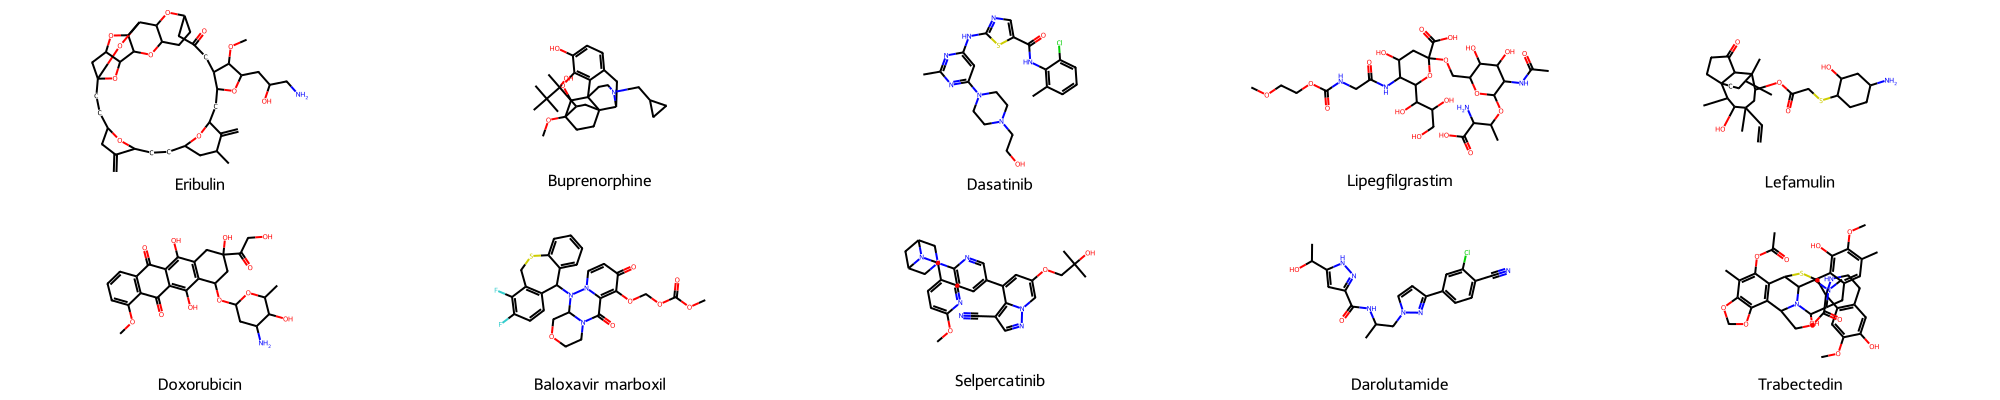

In [30]:
predict_result_sorted_nameInfo_head = predict_result_sorted_nameInfo_head.iloc[[0,1,2,3,4,5,9,10,11,12]]
drugs_name_head = list(predict_result_sorted_nameInfo_head['Name'])
predict_result_sorted_nameInfo_head.mol = predict_result_sorted_nameInfo_head.SmilesForDropDu.apply(Chem.MolFromSmiles)
img_head = Chem.Draw.MolsToGridImage(list(predict_result_sorted_nameInfo_head['mol']),molsPerRow=5,subImgSize=(400,200), returnPNG=False, legends=drugs_name_head)
img_head

molecular weight and logP value calculation

In [31]:
predict_result_sorted_nameInfo_head['mw'] = predict_result_sorted_nameInfo_head.mol.apply(cal_mw)
print(round(np.mean(predict_result_sorted_nameInfo_head.head(10)['mw']),2))
print(round(np.std(predict_result_sorted_nameInfo_head.head(10)['mw']),2))

572.54
118.81


In [32]:
predict_result_sorted_nameInfo_head['logP'] = predict_result_sorted_nameInfo_head.mol.apply(get_logp)
print(round(np.mean(predict_result_sorted_nameInfo_head.head(10)['logP']),2))
print(round(np.std(predict_result_sorted_nameInfo_head.head(10)['logP']),2))

2.11
3.15


##  Tail 10 drugs

In [33]:
drugs_name_tail = list(predict_result_sorted_nameInfo_tail['name_to_use'])
drugs_name_tail[2] = 'futibatinib'
predict_result_sorted_nameInfo_tail['Name'] = drugs_name_tail

In [34]:
predict_result_sorted_nameInfo_tail = predict_result_sorted_nameInfo_tail.iloc[[3,5,6,8,9,10,11,12,13,14]]

In [35]:
drugs_name_tail = list(predict_result_sorted_nameInfo_tail['Name'])

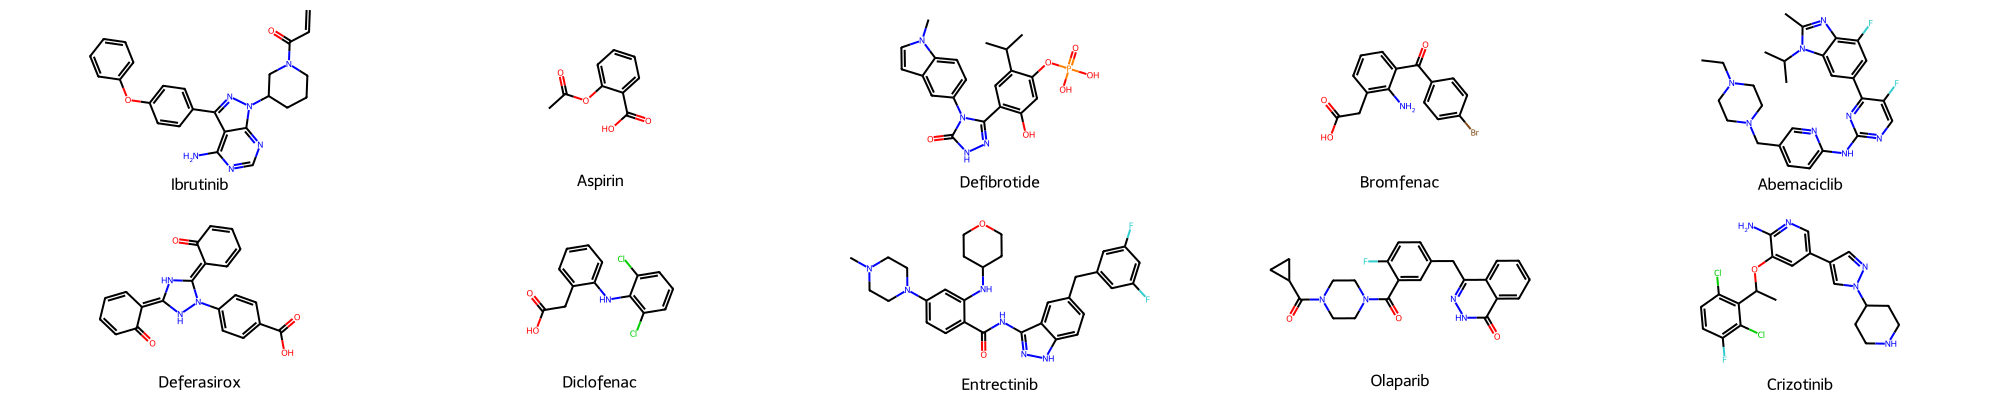

In [36]:
predict_result_sorted_nameInfo_tail.mol = predict_result_sorted_nameInfo_tail.SmilesForDropDu.apply(Chem.MolFromSmiles)
mols = predict_result_sorted_nameInfo_tail['mol'].tolist()[::-1]
legends = drugs_name_tail[::-1]
img_tail = Chem.Draw.MolsToGridImage(list(mols),molsPerRow=5,subImgSize=(400,200), returnPNG=False, legends=legends)
img_tail

molecular weight and logP value calculation

In [37]:
predict_result_sorted_nameInfo_tail['mw'] = predict_result_sorted_nameInfo_tail.mol.apply(cal_mw)
print(round(np.mean(predict_result_sorted_nameInfo_tail['mw']),2))
print(round(np.std(predict_result_sorted_nameInfo_tail['mw']),2))

402.08
104.22


In [38]:
predict_result_sorted_nameInfo_tail['logP'] = predict_result_sorted_nameInfo_tail.mol.apply(get_logp)
print(round(np.mean(predict_result_sorted_nameInfo_tail.head(10)['logP']),2))
print(round(np.std(predict_result_sorted_nameInfo_tail.head(10)['logP']),2))

3.53
1.29


# Correlation between test set compounds' PrOCTOR scores and molecular weight

In [39]:
prediction_combined_feature['mol'] = prediction_combined_feature['smi'].apply(Chem.MolFromSmiles)
prediction_combined_feature['mw'] = prediction_combined_feature['mol'].apply(cal_mw)

In [40]:
prediction_combined_feature['mol'] = prediction_combined_feature['smi'].apply(Chem.MolFromSmiles)
prediction_combined_feature['logP'] = prediction_combined_feature['mol'].apply(get_logp)

In [41]:
predict_result_toxic = prediction_combined_feature[prediction_combined_feature['prediction'] == 'toxic']
predict_result_benign = prediction_combined_feature[prediction_combined_feature['prediction'] == 'benign']

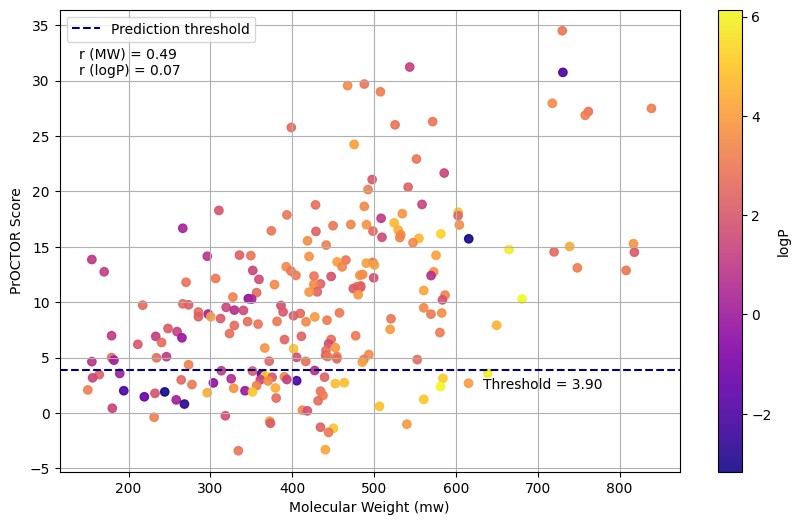

In [42]:
plot_correlation(predict_result_toxic, predict_result_benign)

# Analyze the adverse events for ten predicted toxic and ten predicted benign drugs

Data source: EudraVigilance -- adverse reaction report analysis

In [43]:
pre_benign = pd.read_csv('../Data/predicted_benign_adverse_reaction.csv')
pre_toxic = pd.read_csv('../Data/predicted_toxic_adverse_reaction.csv')

Total number of suspected adverse reactions reported for the selected drugs

In [44]:
pre_benign_1 = pre_benign[pre_benign['Seriousness'] != 'Total'].drop(columns=['Total'])
pre_toxic_1 = pre_toxic[pre_toxic['Seriousness'] != 'Total'].drop(columns=['Total'])

In [45]:
list_of_adverse_reaction = pre_benign_1.iloc[:,3:].columns.tolist()
pre_benign_1[list_of_adverse_reaction] = pre_benign_1[list_of_adverse_reaction].replace(',', '', regex=True).astype(float)
pre_toxic_1[list_of_adverse_reaction] = pre_toxic_1[list_of_adverse_reaction].replace(',', '', regex=True).astype(float)

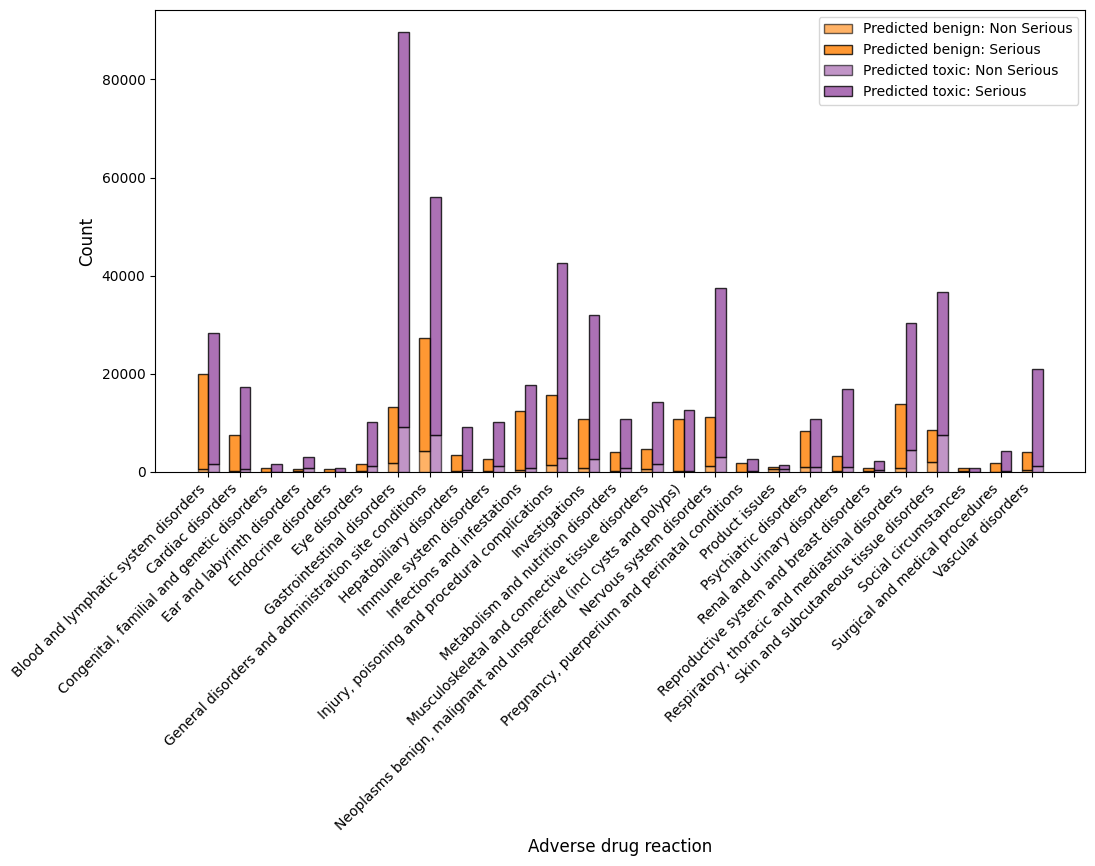

In [46]:
SuspectedAdverseDrugEvents_count(pre_benign_1, pre_toxic_1, list_of_adverse_reaction)

Number of suspected adverse reactions reported for specific drugs

In [47]:
pre_benign_2 = pre_benign[pre_benign['Seriousness'] == 'Total']
pre_toxic_2 = pre_toxic[pre_toxic['Seriousness'] == 'Total']
pre_combine = pd.concat([pre_benign_2,pre_toxic_2]).drop(columns=['Total'])

In [48]:
pre_combine[list_of_adverse_reaction] = pre_combine[list_of_adverse_reaction].replace(',', '', regex=True).astype(float)

In [ ]:
pre_benign_2['Total'] = pre_benign_2['Total'].replace(',', '', regex=True).astype(float)
pre_toxic_2['Total'] = pre_toxic_2['Total'].replace(',', '', regex=True).astype(float)

In [50]:
print(np.mean(pre_benign_2['Total']))
print(np.mean(pre_toxic_2['Total']))

9448.5
25169.6


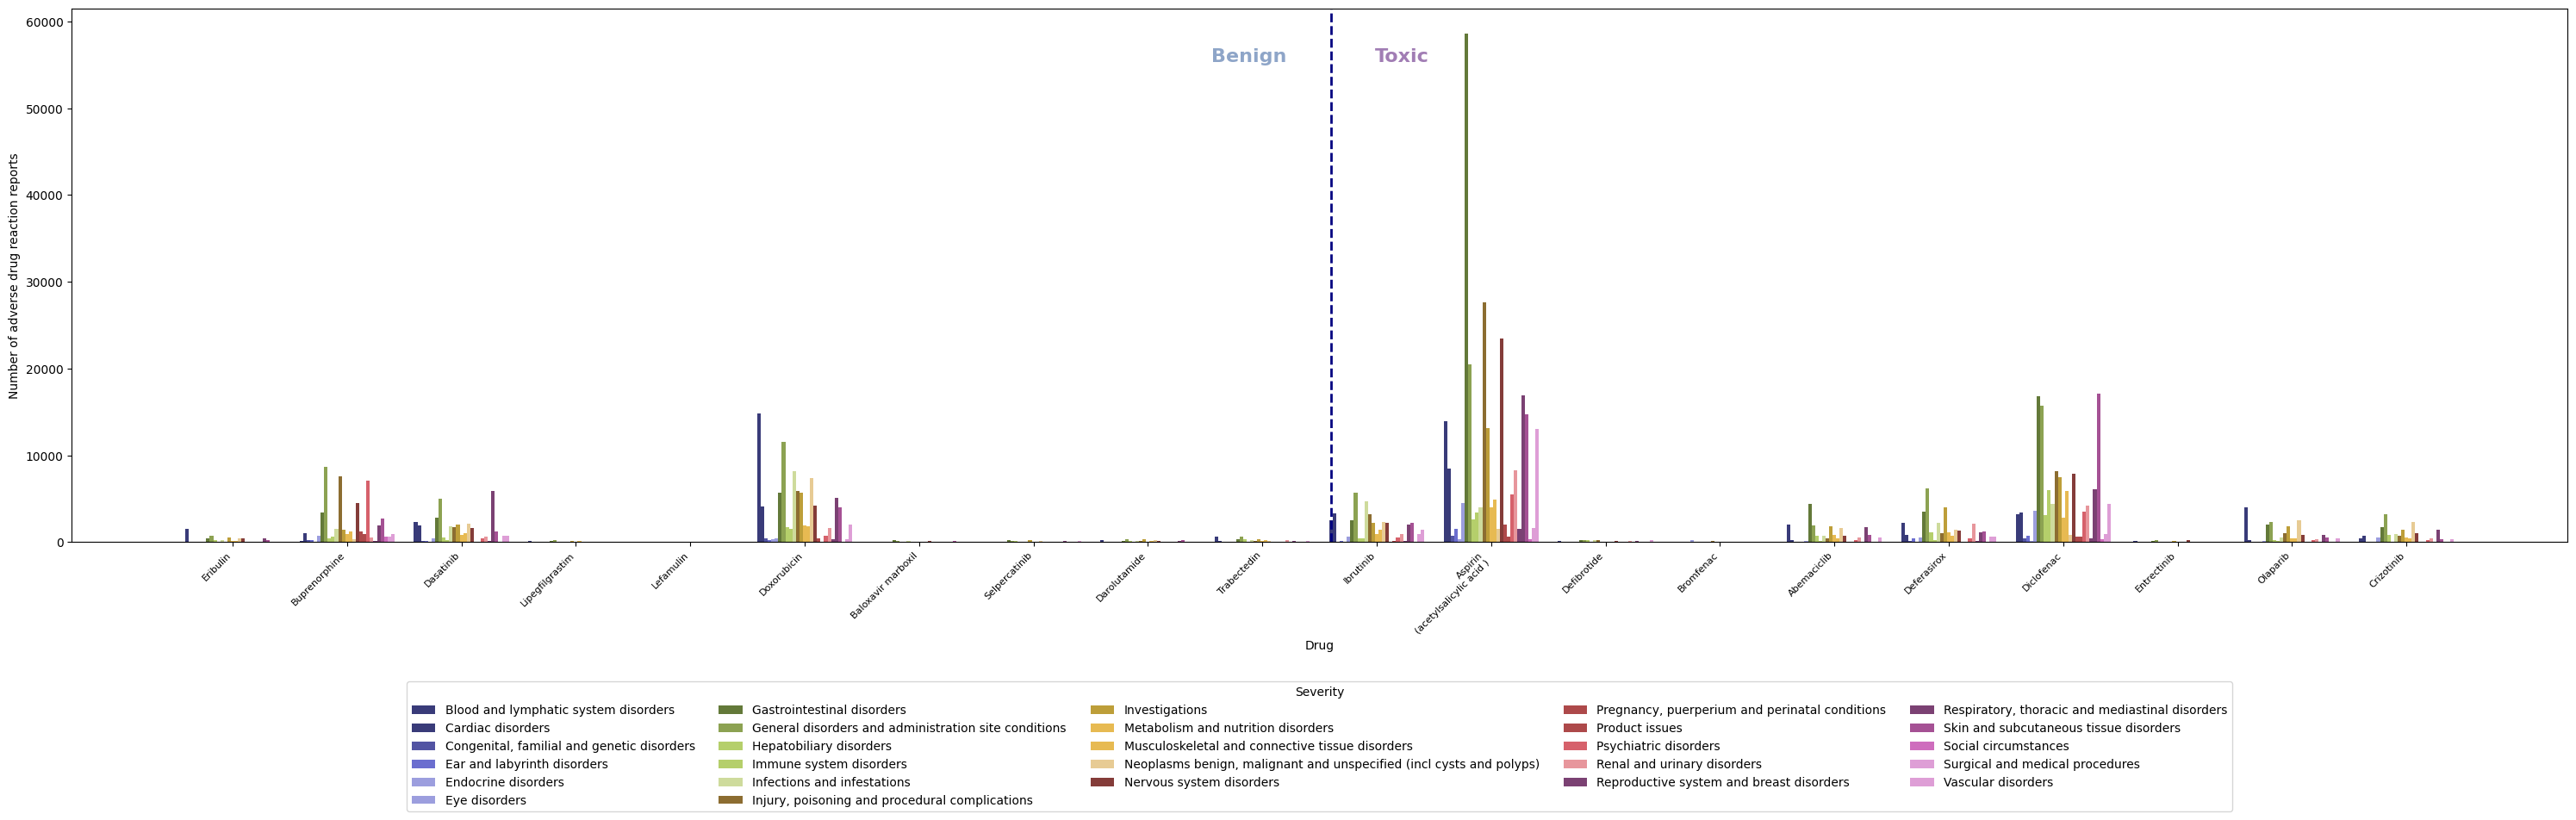

In [51]:
SuspectedAdverseDrugEvents_count_for_eachdrug(pre_combine)

In [52]:
pre_combine['Total'] = pre_combine[list_of_adverse_reaction].sum(axis=1)

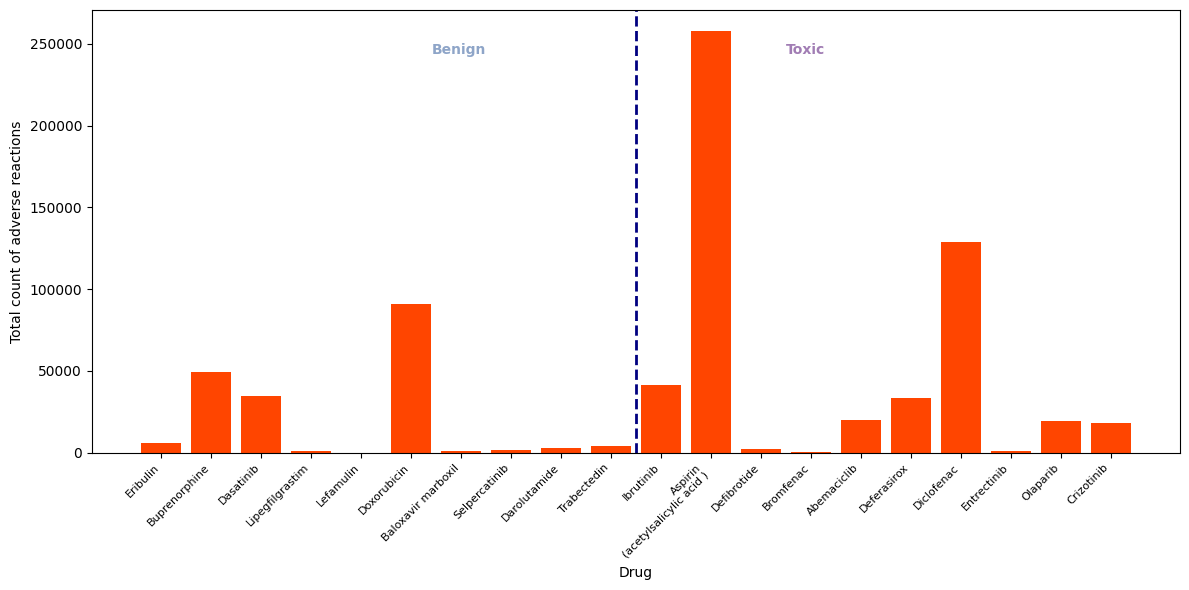

In [53]:
SuspectedAdverseDrugEvents_Totalcount_for_eachdrug(pre_combine)